<a href="https://colab.research.google.com/github/cjvilla/enose_predictions/blob/main/exploratory_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Modules**

In [3]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
raw_data = pd.read_csv('../content/drive/MyDrive/eNose/sensor_data.csv')

In [ ]:
raw_data.columns

Index(['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11',
       'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21',
       'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31',
       'S32', 'real_idn', 'group'],
      dtype='object')

In [5]:
raw_data.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S25,S26,S27,S28,S29,S30,S31,S32,real_idn,group
0,3.835712,4.669524,1.461880,4.352212,0.756478,0.677005,0.943742,3.161918,0.821758,1.174492,...,1.842636,2.643683,0.889705,4.263684,1.913926,2.114062,1.198792,1.094935,MMA045,0
1,3.847488,4.682320,1.464670,4.361580,0.768324,0.679536,0.944552,3.163610,0.823867,1.175820,...,1.846072,2.656102,0.890494,4.285047,1.919609,2.118205,1.478009,1.096809,MMA045,0
2,3.855080,4.691066,1.466731,4.369564,0.781708,0.681342,0.945130,3.165088,0.825759,1.177301,...,1.847187,2.660622,0.890642,4.292239,1.921933,2.119541,1.853633,1.097373,MMA045,0
3,3.857629,4.693313,1.467464,4.371394,0.787963,0.682066,0.945326,3.164504,0.826536,1.177779,...,1.847731,2.662404,0.890850,4.295034,1.923496,2.120260,1.925800,1.097589,MMA045,0
4,3.859445,4.694914,1.467881,4.372620,0.792092,0.682402,0.945419,3.164910,0.826925,1.178111,...,1.848137,2.663836,0.890928,4.297929,1.924176,2.120752,1.935807,1.097782,MMA045,0


# **ETL/Data Cleaning**

In [6]:
demographics = pd.read_csv("/content/drive/MyDrive/eNose/demographics.csv")

In [7]:
# Define a function to map values in the 'Sex' column to 'Sex_Description'
def map_sex_to_description(sex_value):
    if sex_value == 1:
        return 'Female'
    elif sex_value == 2:
        return 'Male'
    else:
        return 'Unknown'  # You can specify a default value for other cases if needed

# Update the 'Sex_Description' column based on the 'Sex' column
demographics['Sex_Description'] = np.vectorize(map_sex_to_description)(demographics['Sex'])


In [8]:
# Define a function to map values in the 'Race' column to 'Race_Description'
def map_race_to_description(race_value):
    if race_value == 1:
        return 'Asian'
    elif race_value == 2:
        return 'Black'
    elif race_value == 3:
        return 'Hispanic'
    elif race_value == 4:
        return 'White'
    else:
        return 'Unknown'  # You can specify a default value for other cases if needed

# Apply the mapping function to create the new column
demographics['Race_Description'] = np.vectorize(map_race_to_description)(demographics['Race'])


In [9]:
# Define a function to map values in the 'Group' column to 'Group_Diagnosis'
def map_group_to_diagnosis(group_value):
    if group_value == 0:
        return 'Healthy Control'
    elif group_value == 1:
        return 'Alcoholic Liver Disease'
    elif group_value == 2:
        return "Parkinson's"
    else:
        return 'Unknown'  # You can specify a default value for other cases if needed

# Apply the mapping function to create the new column
demographics['Group_Diagnosis'] = np.vectorize(map_group_to_diagnosis)(demographics['group'])


In [10]:
# Define the desired column order
desired_column_order = [
    'real_idn', 'Age', 'Sex', 'Sex_Description', 'Race', 'Race_Description', 'BMI',
    'LPS_Endotoxin', 'Perm_sucralose', 'group', 'Group_Diagnosis', 'S1_mean', 'S2_mean',
    'S3_mean', 'S4_mean', 'S5_mean', 'S6_mean', 'S7_mean', 'S8_mean', 'S9_mean',
    'S10_mean', 'S11_mean', 'S12_mean', 'S13_mean', 'S14_mean', 'S15_mean', 'S16_mean',
    'S17_mean', 'S18_mean', 'S19_mean', 'S20_mean', 'S21_mean', 'S22_mean', 'S23_mean',
    'S24_mean', 'S25_mean', 'S26_mean', 'S27_mean', 'S28_mean', 'S29_mean', 'S30_mean',
    'S31_mean', 'S32_mean'
]

# Reorder the columns
demographics = demographics[desired_column_order]


In [11]:
# merging the demographic data columns with sensors of the raw data
demographics = pd.merge(demographics, raw_data, on=['group', 'real_idn'], how='inner')


In [27]:
demographics.head()

,real_idn,Age,Sex,Sex_Description,Race,Race_Description,BMI,LPS_Endotoxin,Perm_sucralose,group,...,S23,S24,S25,S26,S27,S28,S29,S30,S31,S32
0,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.356016,6.294104,1.838590,2.647479,0.886560,4.246110,1.905445,2.117732,1.201969,1.088031
1,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.361753,6.295189,1.839867,2.652587,0.886847,4.255427,1.909048,2.120294,1.285836,1.089582
2,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.377445,6.297019,1.841285,2.658237,0.887237,4.264815,1.911653,2.122250,1.540931,1.090433
3,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.384762,6.298600,1.842100,2.661015,0.887396,4.269175,1.912794,2.123079,1.656784,1.090749
4,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.389403,6.297993,1.842561,2.662513,0.887452,4.272082,1.913618,2.123772,1.708785,1.090944


In [13]:
# Get a list of columns to drop based on the condition
columns_to_drop = [col for col in demographics.columns if '_mean' in col]

# Drop the columns from the DataFrame
demographics = demographics.drop(columns=columns_to_drop)

In [14]:
demographics.to_csv('/content/drive/MyDrive/eNose/Outputs/demographics.csv')

# demographics.to_pdf

In [15]:
demographics.columns

Index(['real_idn', 'Age', 'Sex', 'Sex_Description', 'Race', 'Race_Description',
       'BMI', 'LPS_Endotoxin', 'Perm_sucralose', 'group', 'Group_Diagnosis',
       'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11',
       'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21',
       'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31',
       'S32'],
      dtype='object')

In [16]:
demographics.head() # perm_sucralose directly proportional with leaky gut
# sucralose and endotoxin (combination)
# age, race, sex (combination)
# everything together real_idn (combination)
# each indivdually (except real_idn)


,real_idn,Age,Sex,Sex_Description,Race,Race_Description,BMI,LPS_Endotoxin,Perm_sucralose,group,...,S23,S24,S25,S26,S27,S28,S29,S30,S31,S32
0,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.356016,6.294104,1.838590,2.647479,0.886560,4.246110,1.905445,2.117732,1.201969,1.088031
1,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.361753,6.295189,1.839867,2.652587,0.886847,4.255427,1.909048,2.120294,1.285836,1.089582
2,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.377445,6.297019,1.841285,2.658237,0.887237,4.264815,1.911653,2.122250,1.540931,1.090433
3,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.384762,6.298600,1.842100,2.661015,0.887396,4.269175,1.912794,2.123079,1.656784,1.090749
4,ALD018,63,1,Female,4,White,0.0,1.56,2.934,1,...,2.389403,6.297993,1.842561,2.662513,0.887452,4.272082,1.913618,2.123772,1.708785,1.090944


In [17]:
demographics.columns

Index(['real_idn', 'Age', 'Sex', 'Sex_Description', 'Race', 'Race_Description',
       'BMI', 'LPS_Endotoxin', 'Perm_sucralose', 'group', 'Group_Diagnosis',
       'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11',
       'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21',
       'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31',
       'S32'],
      dtype='object')

# **Testing and Training**

## TCN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your merged_dfset and preprocess it
# Replace 'your_merged_dfset.csv' with your merged_dfset file path

# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 1 for Alcoholic Liver Disease and 2 for Parkinson's

# Split the merged_dfset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input data to include timesteps
# Assuming each sensor reading is treated as a separate timestep
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

# Create a TCN model
def create_tcn_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    return model

# Initialize and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])
tcn_model = create_tcn_model(input_shape)
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the TCN model
epochs = 10
batch_size = 32
tcn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = tcn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/10
139/139 [==============================] - 6s 23ms/step - loss: -2.6745 - accuracy: 0.3191 - val_loss: -18.1520 - val_accuracy: 0.4990
Epoch 2/10
139/139 [==============================] - 2s 17ms/step - loss: -101.0557 - accuracy: 0.4070 - val_loss: -330.5597 - val_accuracy: 0.5030
Epoch 3/10
139/139 [==============================] - 3s 20ms/step - loss: -727.3953 - accuracy: 0.4074 - val_loss: -1622.4956 - val_accuracy: 0.3570
Epoch 4/10
139/139 [==============================] - 2s 16ms/step - loss: -3081.1150 - accuracy: 0.4005 - val_loss: -6026.5381 - val_accuracy: 0.3611
Epoch 5/10
139/139 [==============================] - 2s 13ms/step - loss: -9174.0566 - accuracy: 0.4120 - val_loss: -15840.4404 - val_accuracy: 0.4118
Epoch 6/10
139/139 [==============================] - 2s 14ms/step - loss: -20669.1992 - accuracy: 0.4056 - val_loss: -32297.7559 - val_accuracy: 0.3469
Epoch 7/10
139/139 [==============================] - 2s 12ms/step - loss: -39380.3203 - accuracy: 

## Random Forest Classifier


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load your merged_dfset and preprocess it (as you've done)
# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for Random Forest)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict using the trained Random Forest classifier
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 93.10%


## xgBoost Classification Multiclass

In [ ]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y) for classification
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier with specific hyperparameters
    xgb_classifier = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=100,  # Number of boosting rounds
        max_depth=6,       # Maximum tree depth
        learning_rate=0.1, # Learning rate
        subsample=0.8,     # Fraction of samples used for each tree
    )
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for each class
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_alcoholic_liver_disease = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
    accuracy_parkinsons = accuracy_score(y_test[y_test == 2], y_pred[y_test == 2])

    # Create a DataFrame for the current iteration with model information
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Alcoholic Liver Disease Accuracy': [accuracy_alcoholic_liver_disease],
        'Parkinson\'s Accuracy': [accuracy_parkinsons],
        'Model Info': [str(xgb_classifier)],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_classification_multiclass_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_classification_multiclass_results.head(num_iterations)


,Iteration,Healthy Control Accuracy,Alcoholic Liver Disease Accuracy,Parkinson's Accuracy,Model Info
0,1,0.905473,0.820588,0.726644,"XGBClassifier(base_score=None, booster=None, c..."
1,2,0.898276,0.833819,0.676375,"XGBClassifier(base_score=None, booster=None, c..."
2,3,0.900974,0.800000,0.690722,"XGBClassifier(base_score=None, booster=None, c..."
3,4,0.911223,0.803519,0.704082,"XGBClassifier(base_score=None, booster=None, c..."
4,5,0.909710,0.850299,0.659164,"XGBClassifier(base_score=None, booster=None, c..."
5,6,0.898058,0.814815,0.627760,"XGBClassifier(base_score=None, booster=None, c..."
6,7,0.925801,0.827485,0.676768,"XGBClassifier(base_score=None, booster=None, c..."
7,8,0.899489,0.802469,0.697819,"XGBClassifier(base_score=None, booster=None, c..."
8,9,0.917763,0.849530,0.662295,"XGBClassifier(base_score=None, booster=None, c..."
9,10,0.925424,0.857143,0.608563,"XGBClassifier(base_score=None, booster=None, c..."


In [ ]:
xgboost_classification_multiclass_results.to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_classification_multiclass_results.csv')

## xgBoost Classification Binary

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Load your merged_dfset and preprocess it (as you've done)
# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for XGBoost)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_classifier.fit(X_train, y_train)

# Predict using the trained XGBoost classifier
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 93.53%


## Neural Network (Tensorflow)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

# Load your merged_df dataset and preprocess it (as you've done)
# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
          'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
          'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a simple neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
    keras.layers.Dense(64, activation='relu'),     # Hidden layer with 64 neurons and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')    # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network on your data
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
93/93 [==============================] - 1s 5ms/step - loss: 0.4833 - accuracy: 0.7945 - val_loss: 0.4292 - val_accuracy: 0.8291
Epoch 2/20
93/93 [==============================] - 0s 3ms/step - loss: 0.4293 - accuracy: 0.8241 - val_loss: 0.4069 - val_accuracy: 0.8385
Epoch 3/20
93/93 [==============================] - 0s 3ms/step - loss: 0.4052 - accuracy: 0.8440 - val_loss: 0.3940 - val_accuracy: 0.8398
Epoch 4/20
93/93 [==============================] - 0s 3ms/step - loss: 0.3930 - accuracy: 0.8447 - val_loss: 0.3763 - val_accuracy: 0.8385
Epoch 5/20
93/93 [==============================] - 0s 3ms/step - loss: 0.3796 - accuracy: 0.8501 - val_loss: 0.3685 - val_accuracy: 0.8398
Epoch 6/20
93/93 [==============================] - 0s 3ms/step - loss: 0.3715 - accuracy: 0.8497 - val_loss: 0.3575 - val_accuracy: 0.8398
Epoch 7/20
93/93 [==============================] - 0s 4ms/step - loss: 0.3618 - accuracy: 0.8497 - val_loss: 0.3515 - val_accuracy: 0.8398
Epoch 8/20
93/93 [==

## Long Short-Term Memory (LSTM)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

# Load your merged_df dataset and preprocess it (as you've done)
# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM (assuming time steps)
n_features = X_train.shape[1]
X_train = X_train.reshape(-1, 1, n_features)
X_test = X_test.reshape(-1, 1, n_features)

# Create an LSTM-based model
model = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(1, n_features)),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model on your data
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
93/93 [==============================] - 2s 8ms/step - loss: 0.5254 - accuracy: 0.7911 - val_loss: 0.4652 - val_accuracy: 0.8371
Epoch 2/20
93/93 [==============================] - 0s 4ms/step - loss: 0.4614 - accuracy: 0.8197 - val_loss: 0.4292 - val_accuracy: 0.8371
Epoch 3/20
93/93 [==============================] - 0s 5ms/step - loss: 0.4321 - accuracy: 0.8251 - val_loss: 0.4025 - val_accuracy: 0.8371
Epoch 4/20
93/93 [==============================] - 0s 4ms/step - loss: 0.4032 - accuracy: 0.8325 - val_loss: 0.3765 - val_accuracy: 0.8452
Epoch 5/20
93/93 [==============================] - 0s 4ms/step - loss: 0.3779 - accuracy: 0.8457 - val_loss: 0.3727 - val_accuracy: 0.8398
Epoch 6/20
93/93 [==============================] - 0s 4ms/step - loss: 0.3591 - accuracy: 0.8501 - val_loss: 0.3505 - val_accuracy: 0.8398
Epoch 7/20
93/93 [==============================] - 0s 4ms/step - loss: 0.3431 - accuracy: 0.8501 - val_loss: 0.3373 - val_accuracy: 0.8398
Epoch 8/20
93/93 [==

## AdaBoost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Load your merged_df dataset and preprocess it (as you've done)
# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control and 1 for Alcoholic Liver Disease

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_classes = [0, 1]
X_filtered = X[y.isin(selected_classes)]
y_filtered = y[y.isin(selected_classes)]

# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize the input features (important for AdaBoost)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an AdaBoost classifier with a decision tree as the base estimator
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the AdaBoost classifier on your data
adaboost_classifier.fit(X_train, y_train)

# Predict using the trained AdaBoost classifier
y_pred = adaboost_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 84.59%


# **Chosen algorithm: xgBoost Classification Binary**

### Accuracy

In [ ]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y) for classification
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier with specific hyperparameters
    xgb_classifier = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=100,  # Number of boosting rounds
        max_depth=6,       # Maximum tree depth
        learning_rate=0.1, # Learning rate
        subsample=0.8,     # Fraction of samples used for each tree
    )
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for each class
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_alcoholic_liver_disease = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
    accuracy_parkinsons = accuracy_score(y_test[y_test == 2], y_pred[y_test == 2])

    # Create a DataFrame for the current iteration with model information
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Alcoholic Liver Disease Accuracy': [accuracy_alcoholic_liver_disease],
        'Parkinson\'s Accuracy': [accuracy_parkinsons],
        'Model Info': [str(xgb_classifier)],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_classification_binary_accuracy_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_classification_binary_accuracy_results.head(num_iterations)


,Iteration,Healthy Control Accuracy,Alcoholic Liver Disease Accuracy,Parkinson's Accuracy,Model Info
0,1,0.905473,0.820588,0.726644,"XGBClassifier(base_score=None, booster=None, c..."
1,2,0.898276,0.833819,0.676375,"XGBClassifier(base_score=None, booster=None, c..."
2,3,0.900974,0.800000,0.690722,"XGBClassifier(base_score=None, booster=None, c..."
3,4,0.911223,0.803519,0.704082,"XGBClassifier(base_score=None, booster=None, c..."
4,5,0.909710,0.850299,0.659164,"XGBClassifier(base_score=None, booster=None, c..."
5,6,0.898058,0.814815,0.627760,"XGBClassifier(base_score=None, booster=None, c..."
6,7,0.925801,0.827485,0.676768,"XGBClassifier(base_score=None, booster=None, c..."
7,8,0.899489,0.802469,0.697819,"XGBClassifier(base_score=None, booster=None, c..."
8,9,0.917763,0.849530,0.662295,"XGBClassifier(base_score=None, booster=None, c..."
9,10,0.925424,0.857143,0.608563,"XGBClassifier(base_score=None, booster=None, c..."


In [ ]:
xgboost_classification_binary_accuracy_results.to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_classification_binary_accuracy_results.csv')

### Sensitivity

In [ ]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y) for classification
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier with specific hyperparameters
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',  # Multi-class classification
        num_class=3,                # Number of classes
        random_state=42,
        n_estimators=100,           # Number of boosting rounds
        max_depth=6,                # Maximum tree depth
        learning_rate=0.1,          # Learning rate
        subsample=0.8,              # Fraction of samples used for each tree
    )

    # Perform k-fold cross-validation
    cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')

    # Make predictions on the test set
    xgb_classifier.fit(X_train, y_train)
    y_pred = xgb_classifier.predict(X_test)

    # Calculate confusion matrix and classification report
    confusion = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Healthy Control', 'Alcoholic Liver Disease', 'Parkinson\'s'], output_dict=True)

    # Create a DataFrame for the current iteration with model information and evaluation results
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Cross-Validation Mean Accuracy': [cv_scores.mean()],
        'Cross-Validation Std Dev': [cv_scores.std()],
        'Confusion Matrix': [confusion],
        'Classification Report': [class_report],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_classification_binary_sensitivity_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_classification_binary_sensitivity_results.head(50)

'''
plotly of predicted
'''


'\nplotly of predicted\n'

In [ ]:
xgboost_classification_binary_sensitivity_results.to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_classification_binary_sensitivity_results.csv')

### xgBoost: HC vs. ALD Accuracy

In [ ]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_groups = [0, 1]
X_filtered = X[y.isin(selected_groups)]
y_filtered = y[y.isin(selected_groups)]

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the filtered dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for Healthy Control (0) and Alcoholic Liver Disease (1)
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_alcoholic_liver_disease = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Alcoholic Liver Disease Accuracy': [accuracy_alcoholic_liver_disease],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_ald_binary_accuracy_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_ald_binary_accuracy_results.head(50) # add percent difference as the last column

,Iteration,Healthy Control Accuracy,Alcoholic Liver Disease Accuracy
0,1,0.959933,0.866261
1,2,0.940778,0.896142
2,3,0.944444,0.911932
3,4,0.964401,0.896774
4,5,0.948074,0.924471
5,6,0.972536,0.922330
6,7,0.955519,0.919003
7,8,0.947899,0.894895
8,9,0.951220,0.916933
9,10,0.958264,0.893617


In [ ]:
xgboost_ald_binary_accuracy_results.\
  to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_ald_binary_accuracy_results.csv')

In [ ]:
xgboost_ald_binary_accuracy_results.describe().\
to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_ald_binary_accuracy_results_descriptions.csv') # mean of each individual sensor (32)

### xgBoost: HC vs. ALD Sensitivity

In [ ]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Define features (X) and target variable (y)
X = demographics[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = demographics['group']  # Assuming 0 for Healthy Control, 1 for Alcoholic Liver Disease, and 2 for Parkinson's

# Filter the dataset to include only "Healthy Control" (0) and "Alcoholic Liver Disease" (1)
selected_groups = [0, 1]
X_filtered = X[y.isin(selected_groups)]
y_filtered = y[y.isin(selected_groups)]

# Specify the number of iterations
num_iterations = 32

# Define a function to calculate sensitivity and specificity
def sensitivity_specificity(y_true, y_pred, positive_class=1):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    if positive_class == 1:
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
    else:
        sensitivity = tn / (tn + fp)
        specificity = tp / (tp + fn)
    return sensitivity, specificity

for iteration in range(num_iterations):
    # Split the filtered dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict disease labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate sensitivity and specificity for Healthy Control (0) and Alcoholic Liver Disease (1)
    sensitivity_healthy_control, specificity_healthy_control = sensitivity_specificity(y_test, y_pred, positive_class=0)
    sensitivity_alcoholic_liver_disease, specificity_alcoholic_liver_disease = sensitivity_specificity(y_test, y_pred, positive_class=1)

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Sensitivity': [sensitivity_healthy_control],
        'Alcoholic Liver Disease Sensitivity': [sensitivity_alcoholic_liver_disease],
        'Healthy Control Specificity': [specificity_healthy_control],
        'Alcoholic Liver Disease Specificity': [specificity_alcoholic_liver_disease]
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_ald_binary_sensitivity_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_ald_binary_sensitivity_results.head(num_iterations)


,Iteration,Healthy Control Sensitivity,Alcoholic Liver Disease Sensitivity,Healthy Control Specificity,Alcoholic Liver Disease Specificity
0,1,0.959933,0.866261,0.866261,0.959933
1,2,0.940778,0.896142,0.896142,0.940778
2,3,0.944444,0.911932,0.911932,0.944444
3,4,0.964401,0.896774,0.896774,0.964401
4,5,0.948074,0.924471,0.924471,0.948074
5,6,0.972536,0.922330,0.922330,0.972536
6,7,0.955519,0.919003,0.919003,0.955519
7,8,0.947899,0.894895,0.894895,0.947899
8,9,0.951220,0.916933,0.916933,0.951220
9,10,0.958264,0.893617,0.893617,0.958264


In [ ]:
xgboost_ald_binary_sensitivity_results.head()# individual senosrs

,Iteration,Healthy Control Sensitivity,Alcoholic Liver Disease Sensitivity,Healthy Control Specificity,Alcoholic Liver Disease Specificity
0,1,0.959933,0.866261,0.866261,0.959933
1,2,0.940778,0.896142,0.896142,0.940778
2,3,0.944444,0.911932,0.911932,0.944444
3,4,0.964401,0.896774,0.896774,0.964401
4,5,0.948074,0.924471,0.924471,0.948074


In [ ]:
xgboost_ald_binary_sensitivity_results.\
  to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_ald_binary_sensitivity_results.csv')

In [ ]:
xgboost_ald_binary_sensitivity_results.describe().\
  to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_ald_binary_sensitivity_results_description.csv')

## xgBoost: Control vs. Parkinson's Accuracy

In [ ]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it
# Replace 'your_merged_df.csv' with your dataset file path

# Create an empty list to store DataFrames
results_list = []

# Filter the dataset to include only Healthy Control (group 0) and Parkinson's (group 2)
filtered_df = demographics[(demographics['group'] == 0) | (demographics['group'] == 2)]

# Define features (X) and the modified target variable (y)
X = filtered_df[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = filtered_df['group']  # Assuming 0 for Healthy Control and 2 for Parkinson's

# Map the classes to [0, 1]
class_mapping = {0: 0, 2: 1}  # Map Parkinson's (2) to 1
y = y.map(class_mapping)

# Specify the number of iterations
num_iterations = 32

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict binary labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate accuracy for "Healthy Control" (0) and "Parkinson's" (1)
    accuracy_healthy_control = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    accuracy_parkinsons = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Healthy Control Accuracy': [accuracy_healthy_control],
        'Parkinson\'s Accuracy': [accuracy_parkinsons],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_pd_binary_accuracy_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_pd_binary_accuracy_results.head(num_iterations)


,Iteration,Healthy Control Accuracy,Parkinson's Accuracy
0,1,0.906667,0.822368
1,2,0.905724,0.822581
2,3,0.890344,0.849829
3,4,0.932998,0.846906
4,5,0.922442,0.802013
5,6,0.918333,0.779605
6,7,0.913115,0.792517
7,8,0.942470,0.741214
8,9,0.900974,0.847222
9,10,0.912480,0.815331


In [ ]:
xgboost_pd_binary_accuracy_results.\
  to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_pd_binary_accuracy_results.csv')

In [ ]:
xgboost_pd_binary_accuracy_results.describe().\
  to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_pd_binary_accuracy_results_descriptions.csv')

In [ ]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

# Suppress XGBoost-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load your merged_df dataset and preprocess it (as you've done)

# Create an empty list to store DataFrames
results_list = []

# Filter the dataset to include only Healthy Control (group 0) and Parkinson's (group 2)
filtered_df = demographics[(demographics['group'] == 0) | (demographics['group'] == 2)]

# Define features (X) and the modified target variable (y)
X = filtered_df[['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
              'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
              'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']]
y = filtered_df['group']  # Assuming 0 for Healthy Control and 2 for Parkinson's

# Map the classes to [0, 1]
class_mapping = {0: 0, 2: 1}  # Map Parkinson's (2) to 1
y = y.map(class_mapping)

# Specify the number of iterations
num_iterations = 20

for iteration in range(num_iterations):
    # Split the dataset into training and testing sets with a random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=iteration)

    # Create and train the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    xgb_classifier.fit(X_train, y_train)

    # Predict binary labels on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate sensitivity (True Positive Rate) for "Parkinson's" (1)
    sensitivity_parkinsons = cm[1, 1] / (cm[1, 0] + cm[1, 1])

    # Calculate specificity (True Negative Rate) for "Healthy Control" (0)
    specificity_healthy_control = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    # Create a DataFrame for the current iteration
    iteration_df = pd.DataFrame({
        'Iteration': [iteration + 1],
        'Parkinson\'s Sensitivity': [sensitivity_parkinsons],
        'Healthy Control Specificity': [specificity_healthy_control],
    })

    # Append the DataFrame to the results list
    results_list.append(iteration_df)

# Concatenate all DataFrames in the results list
xgboost_pd_binary_sensitivity_results = pd.concat(results_list, ignore_index=True)

# Display the results DataFrame
xgboost_pd_binary_sensitivity_results.head(num_iterations)


'''
avg of sensitivity and specificity
'''


'\navg of sensitivity and specificity\n'

In [ ]:
xgboost_pd_binary_sensitivity_results.\
  to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_pd_binary_sensitivity_results.csv')

In [ ]:
xgboost_pd_binary_sensitivity_results.\
  to_csv('/content/drive/MyDrive/eNose/Outputs/xgboost_pd_binary_sensitivity_results_description.csv')

# Individual Inputs Influence

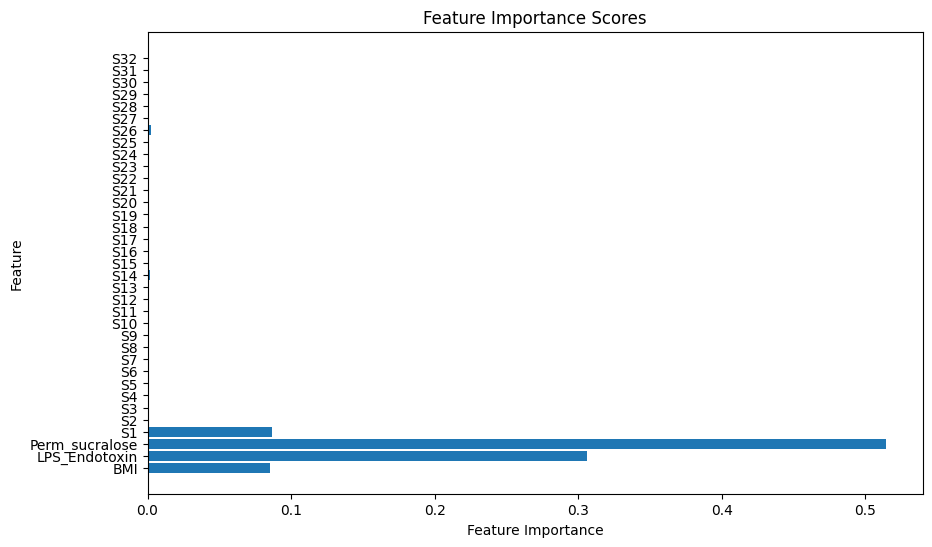

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Step 1: Prepare Data
selected_features = ['BMI', 'LPS_Endotoxin', 'Perm_sucralose', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']
X = demographics[selected_features]  # Features
y = demographics['group']  # Target variable

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train XGBoost Model
model = XGBClassifier()
model.fit(X_train, y_train)

# Step 4: Feature Importance
feature_importance = model.feature_importances_

# Step 5: Visualize or Analyze Importance
plt.figure(figsize=(10, 6))
plt.barh(selected_features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Scores')
plt.show()

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Step 1: Prepare Data
selected_features = ['BMI', 'LPS_Endotoxin', 'Perm_sucralose', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32']
X = demographics[selected_features]  # Features
y = demographics['group']  # Target variable

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train XGBoost Model
model = XGBClassifier()
model.fit(X_train, y_train)

# Step 4: Feature Importance
feature_importance = model.feature_importances_

# Step 5: Convert to DataFrame
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importance})

# Determine if each result is viable or not
threshold = 0.05  # Define a threshold for viability

feature_importance_df['Viable'] = feature_importance_df['Importance'] > threshold

# Print the DataFrame
feature_importance_df.head(50)

,Feature,Importance,Viable
0,BMI,0.085253,True
1,LPS_Endotoxin,0.305735,True
2,Perm_sucralose,0.514038,True
3,S1,0.086629,True
4,S2,0.000187,False
5,S3,0.000251,False
6,S4,0.000091,False
7,S5,0.000000,False
8,S6,0.000000,False
9,S7,0.000000,False


## Best Combination of Features



0.90 - 1.00: Excellent
Scores above 0.90 are typically considered excellent in many applications, but be cautious of overfitting, especially with smaller datasets.

0.80 - 0.90: Good
This range is often regarded as good. It indicates that the model is learning well, though there may be room for improvement.

0.70 - 0.80: Fair
This range is seen as fair. The model is learning but not performing optimally. There might be issues related to data quality, feature selection, or model choice.

0.60 - 0.70: Poor
Scores in this range are often considered poor. They indicate that the model isn't learning enough from the data.
Below 0.60: Fail
Scores below 0.60 typically suggest that the model is not performing well, possibly doing little better than random guessing in some cases.


In [24]:
selected_features = ['BMI', 'LPS_Endotoxin', 'Perm_sucralose', 'S1']

In [25]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Step 1: Prepare Data
X = demographics[selected_features]  # Features
y = demographics['group']  # Target variable

# Step 3: Iterate through all possible combinations of features
def evaluate_feature_combination(feature_combination):
    X_subset = X[list(feature_combination)]
    scores = cross_val_score(model, X_subset, y, cv=5)
    mean_score = scores.mean()
    return mean_score, feature_combination

# Step 4: Initialize dictionary to store best combinations
best_combinations = {}

# Define the unique diagnoses
unique_diagnoses = [1, 0, 2]

# Iterate over each unique diagnosis
for diagnosis in unique_diagnoses:
    y_diagnosis = demographics[demographics['Group_Diagnosis'] == diagnosis]['Group_Diagnosis']
    best_score = -1
    best_feature_combination = None

    results = Parallel(n_jobs=-1)(delayed(evaluate_feature_combination)(feature_combination)
                                  for r in range(1, len(selected_features) + 1)
                                  for feature_combination in combinations(selected_features, r))

    for mean_score, feature_combination in results:
        if mean_score > best_score:
            best_score = mean_score
            best_feature_combination = feature_combination

    best_combinations[diagnosis] = (best_feature_combination, best_score)

# Step 5: Print Best Combination for Each Diagnosis
for diagnosis in best_combinations:
    print(f"Diagnosis: {diagnosis}")
    print("Best combination of features:", best_combinations[diagnosis][0])
    print("Best cross-validation score:", best_combinations[diagnosis][1])
    print()

Diagnosis: 1
Best combination of features: ('LPS_Endotoxin', 'Perm_sucralose', 'S1')
Best cross-validation score: 0.9675324675324675

Diagnosis: 0
Best combination of features: ('LPS_Endotoxin', 'Perm_sucralose', 'S1')
Best cross-validation score: 0.9675324675324675

Diagnosis: 2
Best combination of features: ('LPS_Endotoxin', 'Perm_sucralose', 'S1')
Best cross-validation score: 0.9675324675324675



## Gender, Race, and Age

# Graphs

1. 80-20% graph
2. Comparisons for CNN and xgBoost
*   Accuracy
*   Sensitivity
*   Specificity
3. Graph of demographics and sensors


# Checklist
1. PDF versions of dataframe
2. PDF version of notebook
3. PDF versions of graphs